## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dependencies and Setup
import time
from pprint import pprint
import requests
from datetime import date, timedelta, datetime
import json
from pprint import pprint
from tqdm import tqdm
from tqdm import tqdm_notebook
# sqlite Dependencies
# ----------------------------------
# Imports the method used for connecting to DBs
from sqlalchemy import create_engine
# Allow us to declare column types
from sqlalchemy import Column, Integer, String, Text, DateTime, Float, Boolean, ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

In [2]:
from nba_api.stats.endpoints import playercareerstats, drafthistory, commonplayerinfo, playerawards

-------------

## Open combined data from json

In [33]:
with open('./clean_combined_data_for_ml.json') as json_file:
    data = json.load(json_file)

In [34]:
# Default DF. Do not touch.
default = pd.read_json(data).copy()

## Dataframes for all positions 

#### Key: 

* GP: Games Played
* MIN: Minutes Played
* FGM: Field Goals Made
* FGA: Field Goals Attempted
* FG_PCT: Field Goal Percentage
* 3PM: 3 Point Field Goals Made
* 3PA: 3 Point Field Goals Attempted
* FG3_PCT: 3 Point Field Goals Percentage
* FTM: Free Throws Made
* FTA: Free Throws Attempted
* FT_PCT: Free Throw Percentage
* OREB: Offensive Rebounds
* DREB: Defensive Rebounds
* REB: Rebounds
* AST: Assists
* TOV: Turnovers
* STL: Steals
* BLK: Blocks
* PF: Personal Fouls
* DD2: Double Doubles
* TD3: Trible Doubles
* PTS: Points
* YIL: Year in League


In [89]:
# SG
sg = default[(default['POSITION'] == 'SG') & (default['GP'] > 40)]
sg = sg.drop(columns=['POSITION'])
sg = sg[[ 'PLAYER_ID', 'PLAYER_NAME', 'SEASON_ID','INFLATION','YEAR','YIL', 'PLAYER_AGE', 'GP', 'GS',
         'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'MIN']].sort_values(by='SEASON_ID', ascending=False)
sg = sg.drop_duplicates(subset=['SEASON_ID','PLAYER_AGE','GP','GS','MIN'], keep='first').reset_index(drop=True)
pd.set_option('display.max_columns', None)
sg.copy()

,PLAYER_ID,PLAYER_NAME,SEASON_ID,INFLATION,YEAR,YIL,PLAYER_AGE,GP,GS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,MIN
0,1629013,Landry Shamet,2019-20,1703649,2019,2,23,53,30,158,391,0.404,111,296,0.375,65,76,0.855,6,94,100,99,20,10,42,142,492,1452
1,1627936,Alex Caruso,2019-20,556745,2017,3,26,64,2,120,291,0.412,40,120,0.333,69,94,0.734,17,106,123,124,70,18,53,98,349,1175
2,1629741,Marko Guduric,2019-20,2625000,2020,1,25,44,0,62,157,0.395,25,83,0.301,24,26,0.923,14,59,73,45,12,8,36,34,173,484
3,1629680,Matisse Thybulle,2019-20,2582160,2020,1,23,65,14,112,265,0.423,56,157,0.357,25,41,0.610,44,63,107,79,93,47,51,141,305,1287
4,1629673,Jordan Poole,2019-20,1964760,2020,1,21,57,14,167,502,0.333,74,265,0.279,95,119,0.798,9,109,118,134,35,10,74,94,503,1274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,1749,Cuttino Mobley,2000-01,10240158,2013,3,25,79,49,527,1214,0.434,90,252,0.357,394,474,0.831,83,314,397,195,84,26,165,169,1538,3006
560,1901,Dion Glover,2000-01,1302198,2000,2,22,57,7,141,336,0.420,9,46,0.196,47,69,0.681,39,92,131,69,49,10,54,92,338,931
561,2037,Jamal Crawford,2000-01,5773987,2015,1,21,61,8,107,304,0.352,41,117,0.350,27,34,0.794,9,80,89,141,43,14,85,68,282,1050
562,2050,Morris Peterson,2000-01,1273258,2001,1,23,80,49,290,673,0.431,63,165,0.382,104,145,0.717,112,147,259,105,63,20,78,164,747,1811


In [45]:
# C
c = default[(default['POSITION'] == 'C') & (default['GP'] > 40)]

In [46]:
# SF
sf = default[default['POSITION'] == 'SF']
# PF
pf = default[default['POSITION'] == 'PF']
# PG
pg = default[default['POSITION'] == 'PG']
# G
g = default[default['POSITION'] == 'G']
# F
f = default[default['POSITION'] == 'F']

------------

In [90]:
# dataset = position name
dataset = sg

## Multiple Linear Regressions
X = dataset.iloc[:, 5:-1].values
y = dataset.iloc[:, -1].values

In [92]:
## Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [93]:
## Training the Multiple Linear Regression model on the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [94]:
## Predicting the Test set results
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1720.87 1756.  ]
 [2728.42 3113.  ]
 [1378.   1457.  ]
 [2332.45 2245.  ]
 [1759.14 1912.  ]
 [2798.61 2901.  ]
 [1283.38 1283.  ]
 [ 340.29  359.  ]
 [2074.68 2185.  ]
 [ 438.52  578.  ]
 [1219.97 1188.  ]
 [1832.92 1966.  ]
 [2561.15 2397.  ]
 [1635.79 1791.  ]
 [2205.99 2291.  ]
 [1555.04 1530.  ]
 [1342.95 1139.  ]
 [1861.29 1780.  ]
 [1450.73 1495.  ]
 [2616.87 2566.  ]
 [1686.42 1494.  ]
 [1711.66 1760.  ]
 [ 807.21  679.  ]
 [1362.01 1234.  ]
 [2145.31 2133.  ]
 [ 805.87  896.  ]
 [1562.93 1766.  ]
 [1267.39 1360.  ]
 [1782.89 1738.  ]
 [1888.12 1879.  ]
 [2925.62 2777.  ]
 [1793.73 1843.  ]
 [1691.72 1704.  ]
 [1474.43 1417.  ]
 [ 851.65  813.  ]
 [ 821.03  807.  ]
 [1416.89 1517.  ]
 [1045.42 1177.  ]
 [3060.31 2877.  ]
 [1834.79 1791.  ]
 [2487.23 2458.  ]
 [2678.17 3086.  ]
 [ 477.29  427.  ]
 [1356.12 1368.  ]
 [2213.76 2159.  ]
 [2636.77 2667.  ]
 [1614.02 1553.  ]
 [ 302.07  268.  ]
 [ 583.03  269.  ]
 [2452.74 2379.  ]
 [1979.68 1990.  ]
 [ 379.15  455.  ]
 [1405.37 14

Multiple linear aggression is well adapted to the dataset. 

In [95]:
## R-Square Coefficient 
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9620428882046579

## Input 21 col of values (X) to get minutes played.   
Each value has been passed through regressor to predict how much minutes have been played. Afterwards, we will use predicted minutes played to salary with linear regression. 

example of x passing = [5,26,64,2,120,291,0.412,40,120,0.333,69,94,0.734,17,106,123,124,70,18,53,98,349]

In [135]:
Prediction_result  = ('Predicted Stock Index Price: ', regressor.predict(X))

In [140]:
# Add predicts to MIN_PREDICTIONS (MIN_PRED) column
sg['MIN_PRED'] = Prediction_result[1]
sg['MIN_PRED'] = round(sg['MIN_PRED'], 2)

In [151]:
sg['RISIDUAL'] = sg['MIN_PRED']/sg['MIN']


In [154]:
sg[sg['PLAYER_NAME'] == "Alex Caruso"]

,PLAYER_ID,PLAYER_NAME,SEASON_ID,INFLATION,YEAR,YIL,PLAYER_AGE,GP,GS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,MIN,MIN_PRED,RISIDUAL
1,1627936,Alex Caruso,2019-20,556745,2017,3,26,64,2,120,291,0.412,40,120,0.333,69,94,0.734,17,106,123,124,70,18,53,98,349,1175,1169.52,0.995336


Regression 2
### MIN_PRED will be in a dataframe with injuries, bmi rank, all risidual rankings, PLAYER_ID, PLAYER_NAME, SEASON_ID, INFLATION
this dataframe will run another multiple linear regression. The dependent var will be salary. 
Seperating all the data by position may not be necessary. We could possibly run this model workflow on the full dataset. 

In [274]:
## Dropping risidual due to no correlation with other featuers. Will use to verify testings.
sg_rank = sg.copy()
sg_rank = sg_rank[['PLAYER_ID', 'PLAYER_NAME', 'SEASON_ID', 'YEAR', 'REB','AST','STL', 'MIN_PRED', 'INFLATION']]
sg_rank

,PLAYER_ID,PLAYER_NAME,SEASON_ID,YEAR,REB,AST,STL,MIN_PRED,INFLATION
0,1629013,Landry Shamet,2019-20,2019,100,99,20,1285.30,1703649
1,1627936,Alex Caruso,2019-20,2017,123,124,70,1169.52,556745
2,1629741,Marko Guduric,2019-20,2020,73,45,12,508.47,2625000
3,1629680,Matisse Thybulle,2019-20,2020,107,79,93,1220.42,2582160
4,1629673,Jordan Poole,2019-20,2020,118,134,35,1146.32,1964760
...,...,...,...,...,...,...,...,...,...
559,1749,Cuttino Mobley,2000-01,2013,397,195,84,2614.98,10240158
560,1901,Dion Glover,2000-01,2000,131,69,49,972.60,1302198
561,2037,Jamal Crawford,2000-01,2015,89,141,43,916.11,5773987
562,2050,Morris Peterson,2000-01,2001,259,105,63,1945.57,1273258


In [275]:
# dataset = position name
dataset2 = sg_rank

## Multiple Linear Regressions
X = dataset2.iloc[:, 4:-1].values
y = dataset2.iloc[:, -1].values

In [276]:
X

array([[ 100.  ,   99.  ,   20.  , 1285.3 ],
       [ 123.  ,  124.  ,   70.  , 1169.52],
       [  73.  ,   45.  ,   12.  ,  508.47],
       ...,
       [  89.  ,  141.  ,   43.  ,  916.11],
       [ 259.  ,  105.  ,   63.  , 1945.57],
       [  87.  ,   27.  ,   18.  ,  424.84]])

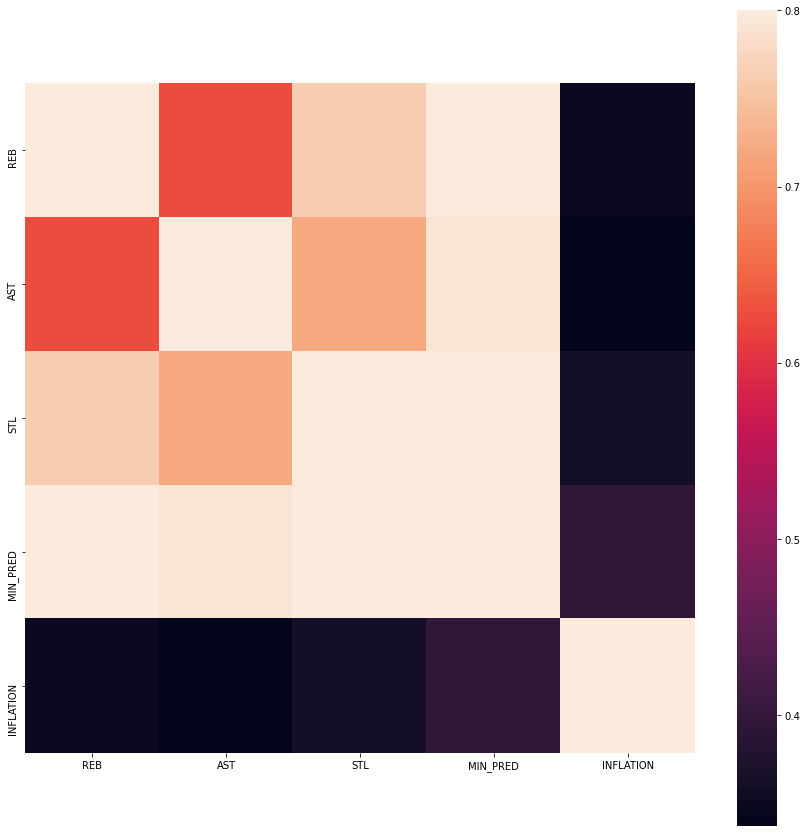

In [277]:
## Check correlation to features
train_data = dataset2.iloc[:, 4:]
# train_data['INFLATION'] = y 

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [306]:
## Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

In [307]:
## Training the Multiple Linear Regression model on the Training set
from sklearn.linear_model import LinearRegression
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)

LinearRegression()

In [308]:
## Predicting the Test set results
y_pred = regressor2.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[8.58e+06 5.05e+06]
 [3.37e+06 8.16e+05]
 [1.66e+06 1.00e+06]
 [4.19e+06 5.20e+05]
 [5.89e+06 4.50e+06]
 [6.41e+06 7.06e+06]
 [3.48e+06 9.91e+05]
 [5.60e+06 4.84e+06]
 [2.13e+06 1.42e+06]
 [6.76e+06 1.20e+07]
 [3.91e+06 3.57e+06]
 [7.58e+06 2.93e+06]
 [6.06e+06 1.23e+07]
 [4.12e+05 2.12e+06]
 [3.53e+06 3.91e+06]
 [1.44e+06 1.38e+06]
 [1.82e+06 2.55e+06]
 [6.57e+06 9.54e+05]
 [6.36e+06 2.46e+06]
 [4.67e+06 3.17e+06]
 [8.03e+06 5.27e+05]
 [1.11e+07 5.13e+06]
 [6.06e+06 7.00e+06]
 [5.79e+06 2.12e+05]
 [7.16e+06 1.40e+07]
 [3.73e+06 1.13e+06]
 [6.39e+06 1.42e+07]
 [4.36e+05 2.25e+06]
 [1.11e+07 4.81e+06]
 [6.52e+06 2.88e+06]
 [6.22e+06 1.40e+07]
 [3.50e+06 1.42e+06]
 [6.28e+06 8.53e+06]
 [2.51e+06 9.38e+05]
 [6.80e+05 5.11e+05]
 [8.79e+06 1.72e+07]
 [2.96e+06 8.41e+05]
 [8.60e+06 2.66e+06]
 [9.68e+06 8.99e+05]
 [3.48e+06 3.11e+06]
 [4.80e+06 1.62e+07]
 [8.26e+06 1.90e+07]
 [2.70e+06 7.53e+04]
 [8.12e+06 1.15e+07]
 [9.45e+05 1.38e+06]
 [1.31e+06 1.57e+06]
 [1.86e+06 5.27e+06]
 [1.02e+06 1.

In [309]:
## R-Square Coefficient 
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.1341718088204915

## Heatmap to display correlations of all features

In [56]:
import seaborn as sb

In [57]:
dataset.iloc[:, 5:]

,YEAR,PLAYER_AGE,GP,GS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,MIN
0,2019,23,53,30,158,391,0.404,111,296,0.375,...,6,94,100,99,20,10,42,142,492,1452
1,2017,26,64,2,120,291,0.412,40,120,0.333,...,17,106,123,124,70,18,53,98,349,1175
2,2020,25,44,0,62,157,0.395,25,83,0.301,...,14,59,73,45,12,8,36,34,173,484
3,2020,23,65,14,112,265,0.423,56,157,0.357,...,44,63,107,79,93,47,51,141,305,1287
4,2020,21,57,14,167,502,0.333,74,265,0.279,...,9,109,118,134,35,10,74,94,503,1274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2013,25,79,49,527,1214,0.434,90,252,0.357,...,83,314,397,195,84,26,165,169,1538,3006
560,2000,22,57,7,141,336,0.420,9,46,0.196,...,39,92,131,69,49,10,54,92,338,931
561,2015,21,61,8,107,304,0.352,41,117,0.350,...,9,80,89,141,43,14,85,68,282,1050
562,2001,23,80,49,290,673,0.431,63,165,0.382,...,112,147,259,105,63,20,78,164,747,1811


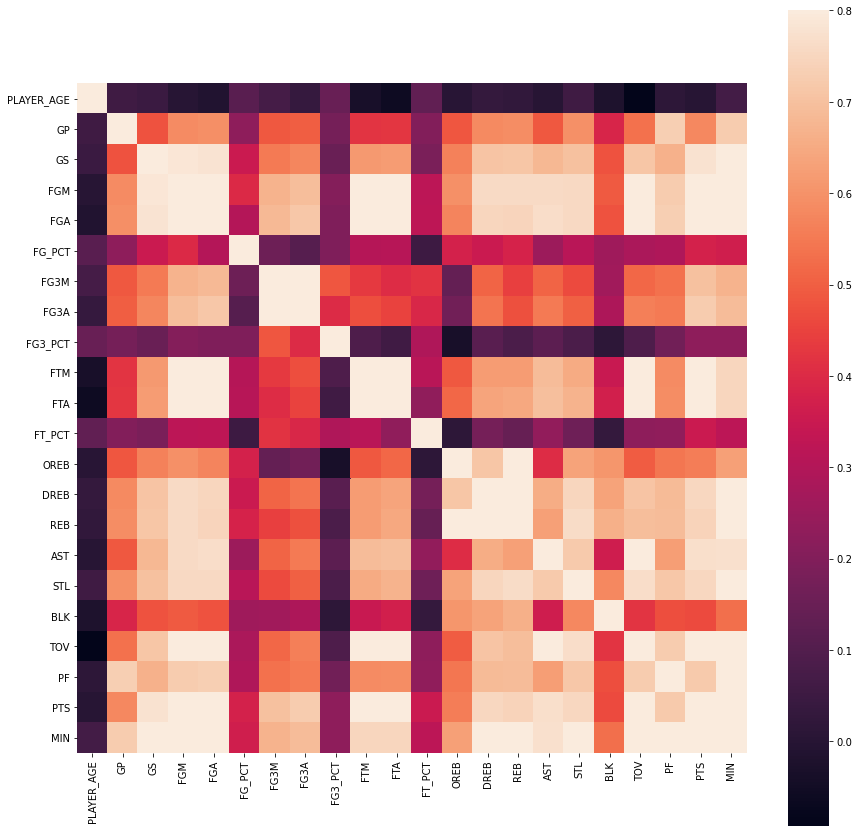

In [58]:
train_data = dataset.iloc[:, 6:]
# train_data['INFLATION'] = y 

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

After reviewing which feature has most impact to one another, Year has little to no coorilation for other featuers other than Inflation. Inflation already calculates year difference. Additionally, Player age has little to no coorilation with other features besides FG_PCT, FG3_PCT, and FT_PCT.

## Linear Regression 

In [ ]:
# Assign the data to X and y

X = twenty_years_all_players[["MIN", "GP"]]
y = twenty_years_all_players["PPGP"].values.reshape(-1, 1)
print(X.shape, y.shape)

In [ ]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)



print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

In [ ]:
# Plot the Residuals for the Training and Testing data

# Use `model.predict()` to get a prediction array from X_train and X_test
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

# Plot the residual
plt.scatter(y_train_prediction, y_train_prediction - y_train, c="blue", label="Training Data (Points)")
plt.scatter(y_test_prediction, y_test_prediction - y_test, c="orange", label="Testing Data (MIN, GP)")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")


--------------------------

## Logistic Regression
* Assiging 'dummies'.        
Creating columns for logistic regression out of categorical data in specific columns. ex: positon of player

In [ ]:
# twenty_years_all_players

In [ ]:
ml_test = twenty_years_all_players.drop(columns=['PLAYER_NAME','TEAM_ABBREVIATION','SEASON_ID'])

In [ ]:
ml_test2 = pd.get_dummies(ml_test)
ml_test2.columns = ml_test2.columns.str.replace(' ','')
ml_test2.head()

OREB: Offensive Rebounds  
DREB: Defensive Rebounds   
REB: Rebounds  
AST: Assists  
TOV: Turnovers  
STL: Steals  
BLK: Blocks  

In [ ]:
X = ml_test2[["MIN", "GP"]]
# Select the 'FEV' column for y, and then use values.reshape() to reshape it to a 2d array
y = ml_test2["POSITION_C"].values.reshape(-1, 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.33,)



In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

In [ ]:
# Generate a new data point (the red circle)
import numpy as np
new_data = np.array([[800, 36]])
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y) 
plt.scatter(new_data[0, 0], new_data[0, 1], c="r", marker="o", s=100)

In [ ]:
# Predict the class (purple or yellow) of the new data point
predictions = classifier.predict(new_data)
print("Classes are either 0 (purple) or 1 (yellow)")
print(f"The new point was classified as: {predictions}")

In [ ]:
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

----------

## TEST: DNN for regression    
https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [ ]:
X = ml_test2[["MIN", "GP"]]
# Select the 'FEV' column for y, and then use values.reshape() to reshape it to a 2d array
y = ml_test2["POSITION_C"].values.reshape(-1, 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.33)

In [ ]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [ ]:
# define a function to get the columns that don’t have any missing values
num_cols = get_cols_with_no_nans(ml_test2 , 'num')
cat_cols = get_cols_with_no_nans(ml_test2 , 'no_num')

In [ ]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

In [ ]:
combined = ml_test2[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

In [ ]:
import seaborn as sb

In [ ]:
train_data = combined[num_cols + cat_cols]
train_data['POSITION_C'] = y 

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

In [ ]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

-----------

## TEST: DNN.
Sequential model, dense layers, relu as activation function for hidden layers, normal initializer as kernel_initializer. Mean absolute error as loss function. Linear as activation function for output

In [ ]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [ ]:
# Transform the training and testing data using the X_scaler

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# One-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model = Sequential()
model.add(Dense(units=6, activation='relu', input_dim=2, name='hidden'))
model.add(Dense(units=2, activation='softmax', name='output'))

In [ ]:
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [ ]:
# Fit the model to the training data
model.fit(
    X_train_scaled,
    y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=60,
    shuffle=True,
    verbose=2
)

### TEST: Deep Learning

In [ ]:
deep_model = Sequential(name='deep_model')
deep_model.add(Dense(units=6, activation='relu', input_dim=2, name='hidden'))
deep_model.add(Dense(units=6, activation='relu', name='hidden_2'))
deep_model.add(Dense(units=2, activation='softmax', name='output'))

In [ ]:
deep_model.summary()

In [ ]:
# deep_model.compile(optimizer='adam',
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

# deep_model.compile(optimizer='adam',
#                    loss='mean_absolute_error',
#                    metrics=['mean_absolute_error'])
# deep_model.fit(
#     X_train_scaled,
#     y_train_categorical,
#     validation_data=(X_test_scaled, y_test_categorical),
#     epochs=100,
#     shuffle=True,
#     verbose=2
# )

In [ ]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
deep_model.fit(
    X_train_scaled,
    y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=100,
    shuffle=True,
    verbose=2
)

### Compare the models below

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

-----------------

In [ ]:
import tensorflow.keras as keras

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

--------

In [ ]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01)
ridge.fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

In [ ]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01)
elasticnet.fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")


---------------